In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
def generate_alpha_helices(n_samples=100, length=10, noise_std=0.1, seed=None):
    """
    Generate synthetic alpha-helical peptides as 3D coordinate chains.
    Gen-AI produced function

    Args:
        n_samples (int): Number of peptide chains to generate.
        length (int): Number of residues per peptide.
        noise_std (float): Std. dev. of Gaussian noise added to coordinates.
        seed (int or None): Optional random seed for reproducibility.

    Returns:
        np.ndarray: Shape (n_samples, length, 3), 3D coordinates of peptides.
    """
    if seed is not None:
        np.random.seed(seed)

    helices = np.zeros((n_samples, length, 3))

    # Helix parameters
    residues_per_turn = 3.6
    rise_per_residue = 1.5   # Å
    radius = 2.0             # Å

    for i in range(n_samples):
        coords = []
        for j in range(length):
            theta = (2 * np.pi / residues_per_turn) * j
            x = radius * np.cos(theta)
            y = radius * np.sin(theta)
            z = rise_per_residue * j

            coords.append([x, y, z])

        coords = np.array(coords)

        # Add Gaussian noise to simulate natural flexibility
        if noise_std > 0:
            coords += np.random.normal(scale=noise_std, size=coords.shape)

        helices[i] = coords

    return helices


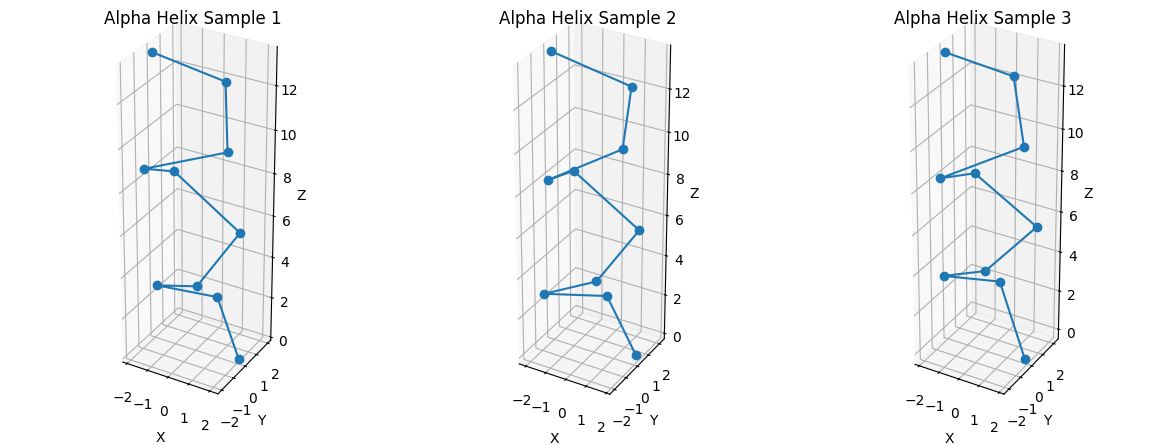

In [ ]:
# Generate some sample helices
sample_helices = generate_alpha_helices(n_samples=3, length=10, noise_std=0.2, seed=42)

# Plot the generated helices
fig = plt.figure(figsize=(12, 4))

for i in range(sample_helices.shape[0]):
    ax = fig.add_subplot(1, sample_helices.shape[0], i + 1, projection='3d')
    ax.plot(sample_helices[i, :, 0], sample_helices[i, :, 1], sample_helices[i, :, 2], marker='o')
    ax.set_title(f'Alpha Helix Sample {i+1}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

In [ ]:
def generate_gaussian_samples(num_samples = 5, length=10, dim=3):
    samples = np.random.randn(num_samples, length, dim)
    return samples

generate_gaussian_samples()

array([[[ 0.09707755,  0.96864499, -0.70205309],
        [-0.32766215, -0.39210815, -1.46351495],
        [ 0.29612028,  0.26105527,  0.00511346],
        [-0.23458713, -1.41537074, -0.42064532],
        [-0.34271452, -0.80227727, -0.16128571],
        [ 0.40405086,  1.8861859 ,  0.17457781],
        [ 0.25755039, -0.07444592, -1.91877122],
        [-0.02651388,  0.06023021,  2.46324211],
        [-0.19236096,  0.30154734, -0.03471177],
        [-1.16867804,  1.14282281,  0.75193303]],

       [[ 0.79103195, -0.90938745,  1.40279431],
        [-1.40185106,  0.58685709,  2.19045563],
        [-0.99053633, -0.56629773,  0.09965137],
        [-0.50347565, -1.55066343,  0.06856297],
        [-1.06230371,  0.47359243, -0.91942423],
        [ 1.54993441, -0.78325329, -0.32206152],
        [ 0.81351722, -1.23086432,  0.22745993],
        [ 1.30714275, -1.60748323,  0.18463386],
        [ 0.25988279,  0.78182287, -1.23695071],
        [-1.32045661,  0.52194157,  0.29698467]],

       [[ 0.2504

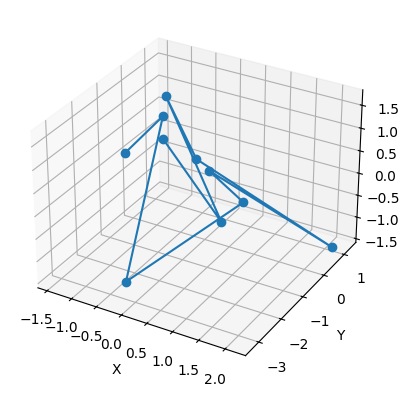

In [ ]:
gaussian_sample = generate_gaussian_samples(num_samples=1)[0]


# Extract x, y, z columns
x, y, z = gaussian_sample[:, 0], gaussian_sample[:, 1], gaussian_sample[:, 2]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(x, y, z, marker='o')  # connected line with markers
# Alternatively: ax.scatter(x, y, z)  # just points

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.show()

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F


device = "cuda" if torch.cuda.is_available() else "cpu"


class FlowModel(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv1d(5, 32, kernel_size=3, padding=1),  # layer 1
            nn.ReLU(),
            nn.Conv1d(32, 3, kernel_size=1)              # layer 2
        )

    def forward(self, x_t, t):
        """
        Args:
            x_t: Tensor of shape (batch_size, L, 3) — interpolated points
            t:   Tensor of shape (batch_size,) — time scalars

        Returns:
            v_t: Tensor of shape (batch_size, L, 3) — predicted velocity vectors
        """
        B, L, _ = x_t.shape
        t = t.view(B, 1, 1).expand(B, L, 1)  # shape: (batch size, peptide len, 1)

        pos = torch.arange(L).float() / (L - 1)  # Normalize to [0, 1]
        pos = pos.view(1, L, 1).expand(B, L, 1)  # shape: (B, L, 1)
        pos = pos.to(device)

        xt_input = torch.cat([x_t, t, pos], dim=-1)  # shape: (batch size, peptide len, 5)
        xt_input = xt_input.permute(0, 2, 1)  # shape: (batch size, 5, peptide len)
        v_t = self.model(xt_input)  # shape: (batch size, 3, peptide len)
        return v_t.permute(0, 2, 1)  # shape: (batch size, peptide len, 3)

# Instantiate model and optimizer
model = FlowModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


peptide_len = 10 #length of chain
dim = 3 #each C-alpha atom will be getting plotted in 3d space

# Training loop
def train(model, steps=100000, batch_size=1024):
    model.train()
    for step in range(steps):
        # Sample from coupling
        x_base = torch.tensor(generate_gaussian_samples(num_samples=batch_size, length=peptide_len, dim=dim), dtype=torch.float32).to(device)  # (batch sz, peptide len, 3)
        x_target = torch.tensor(generate_alpha_helices(n_samples=batch_size, length=peptide_len), dtype=torch.float32).to(device) # (batch sz, peptide_len, 3)
        v_true = x_target - x_base  # (batch sz, peptide_len, 3)

        t = torch.rand(batch_size, device=device)  # (batch_size,)

        t = t.view(batch_size, 1, 1)
        x_t = t* x_target + (1-t) * x_base #linear interpolation; t=0 -> x_base; t=1 -> x_target

        # Predict velocity
        #x_t is of shape (batch size, peptide len, 3)
        v_hat = model(x_t, t)

        loss = F.mse_loss(v_hat, v_true)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 10000 == 0:
            print(f"[{step}] Loss: {loss.item():.6f}")

# Run training
train(model)


[0] Loss: 27.158194
[10000] Loss: 0.632340
[20000] Loss: 0.558992
[30000] Loss: 0.375387
[40000] Loss: 0.284154
[50000] Loss: 0.261750
[60000] Loss: 0.217929
[70000] Loss: 0.211457
[80000] Loss: 0.208903
[90000] Loss: 0.232386


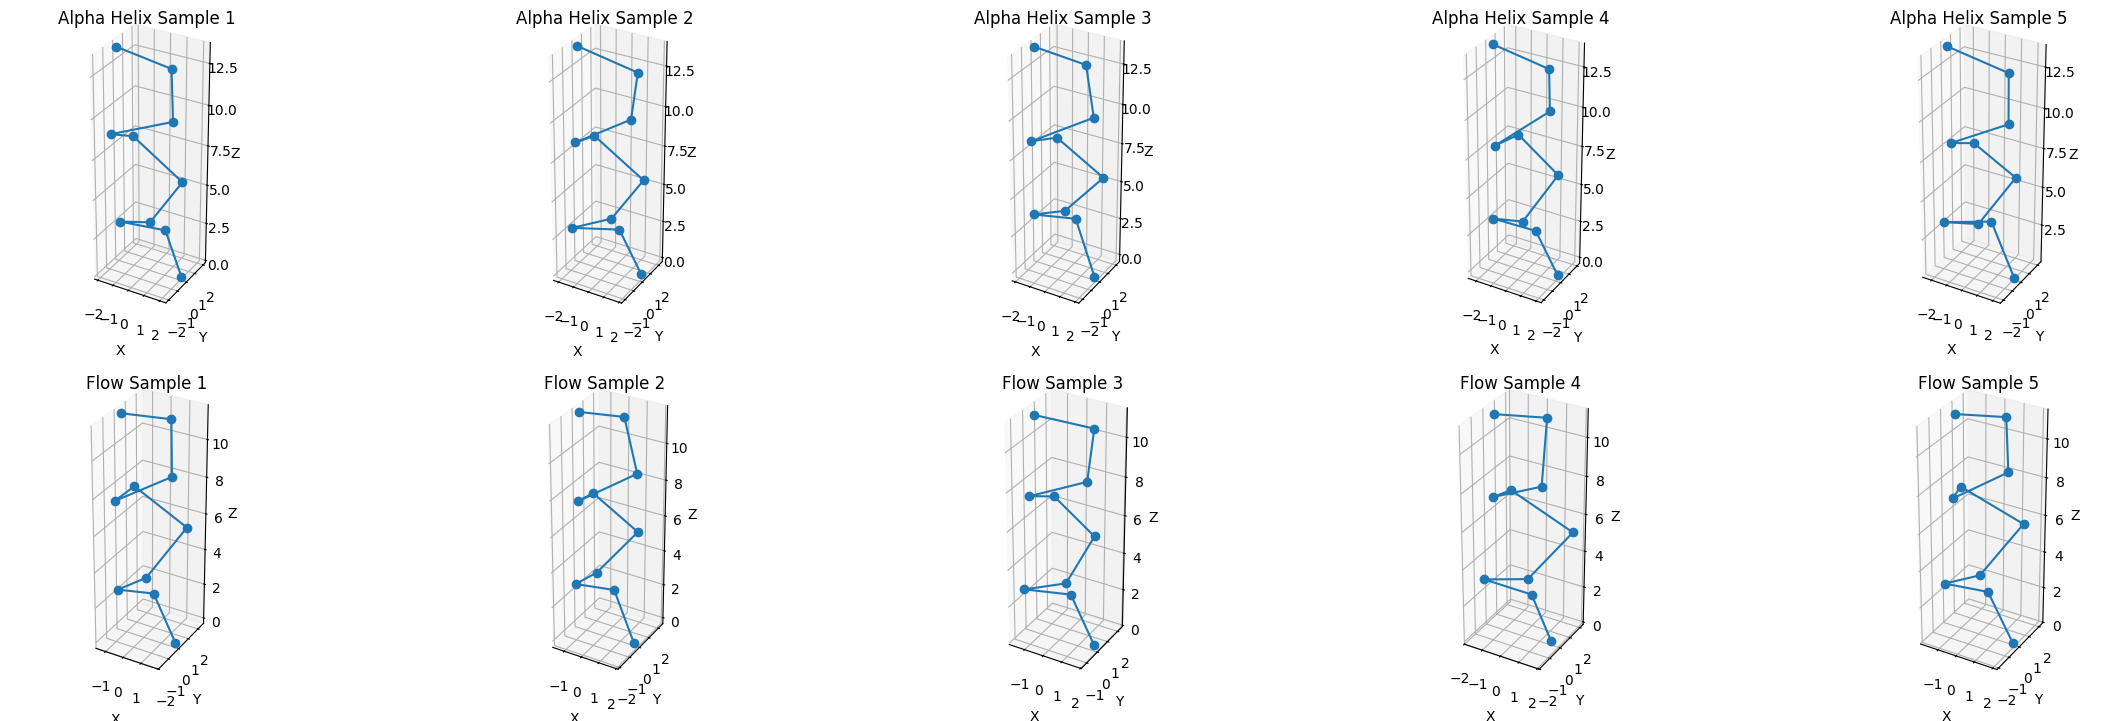

In [16]:
@torch.no_grad()
def sample_from_flow(model, n_samples=5, n_steps=10000):
    model.eval()
    x = torch.tensor(generate_gaussian_samples(num_samples=n_samples), dtype=torch.float32).to(device)  # Start at t=1
    t_vals = torch.linspace(1.0, 0.0, steps=n_steps + 1).to(device)

    for i in range(n_steps):
        t = t_vals[i]
        dt = t_vals[i] - t_vals[i+1]  # positive step size
        v = model(x, t.expand(n_samples))
        x = x + dt * v

    return x.cpu().numpy()  # shape: (n_samples, 2)

samples = sample_from_flow(model)

sample_from_real_target = generate_alpha_helices(n_samples=5, length=10, noise_std=0.2, seed=42)

# Plot the generated helices
fig = plt.figure(figsize=(24, 8))

for i in range(sample_from_real_target.shape[0]):
    ax = fig.add_subplot(2, sample_from_real_target.shape[0], i + 1, projection='3d')
    ax.plot(sample_from_real_target[i, :, 0], sample_from_real_target[i, :, 1], sample_from_real_target[i, :, 2], marker='o')
    ax.set_title(f'Alpha Helix Sample {i+1}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_aspect('equal', adjustable='box')

for i in range(samples.shape[0]):
    ax = fig.add_subplot(2, sample_from_real_target.shape[0], sample_from_real_target.shape[0] + i + 1, projection='3d')
    ax.plot(samples[i, :, 0], samples[i, :, 1], samples[i, :, 2], marker='o')
    ax.set_title(f'Flow Sample {i+1}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_aspect('equal', adjustable='box')


fig.tight_layout(pad=5.0) # Increased padding
plt.show()